In [1]:
!git clone https://github.com/nilrema/TraffiKING.git

Cloning into 'TraffiKING'...
remote: Enumerating objects: 116, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 116 (delta 8), reused 16 (delta 6), pack-reused 95 (from 1)
Receiving objects: 100% (116/116), 113.28 MiB | 13.11 MiB/s, done.
Resolving deltas: 100% (46/46), done.


In [2]:
import os
os.chdir('/content/TraffiKING')

## Dataset


In [3]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Downloadanje

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")

print("Path to dataset files:", path)

100%|██████████| 612M/612M [00:03<00:00, 188MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1


### Kopiranje u Colab folder

In [5]:
!cp -r /root/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1 /content/gtsrb-german-traffic-sign

## Priprema podataka

### Učitavanje podataka

In [6]:
import os
import cv2
import numpy as np

train_folder = "/content/gtsrb-german-traffic-sign/Train"
categories = 43
image_size = (64, 64)

train_images = []
train_labels = []

for label in range(categories):
    category_path = os.path.join(train_folder, str(label)) # folder path
    image_files = os.listdir(category_path)

    for image_file in image_files:
        image_path = os.path.join(category_path, image_file)
        image = cv2.imread(image_path)

        if image is not None:
            image = cv2.resize(image, image_size)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            train_images.append(image)
            train_labels.append(label)

train_images = np.array(train_images)
train_labels = np.array(train_labels)

print("Shape of train_images:", train_images.shape)  # (num_images, 32, 32, 3)
print("Shape of train_labels:", train_labels.shape)  # (num_images,)
# broj primjera, dimenzija x dimenzija, broj kanala (RGB pa je 3)

Shape of train_images: (39209, 64, 64, 3)
Shape of train_labels: (39209,)


In [7]:
print("Train labels head: ", train_labels[:5])  # [0 0 0 0 0]

Train labels head:  [0 0 0 0 0]


### Visualizacija dijela podataka

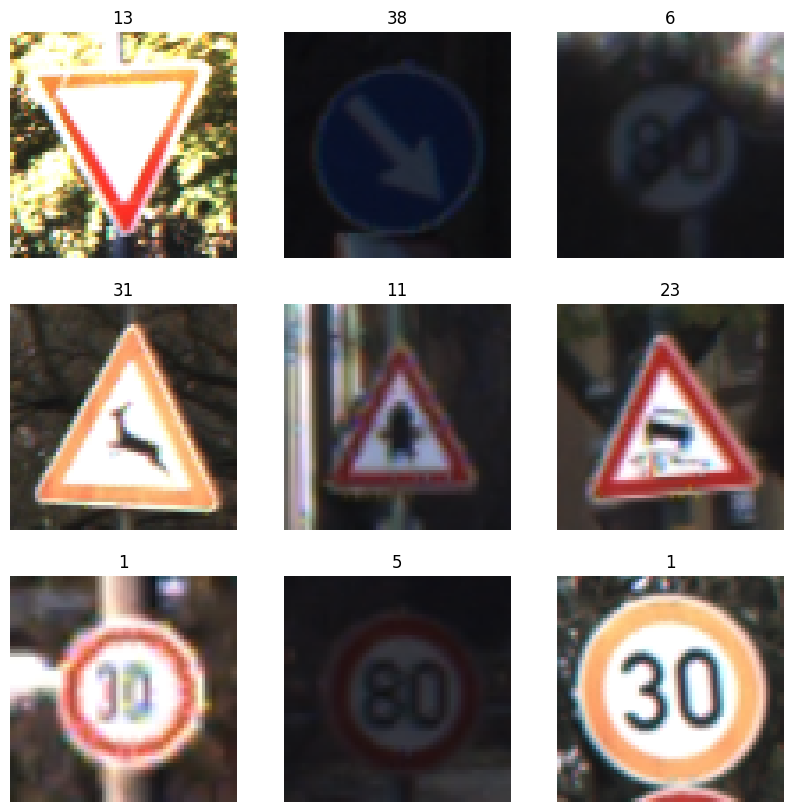

In [8]:
# visualize 9 images in 3x3 grid
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

indices = np.random.choice(len(train_images), 9)
for i, idx in enumerate(indices):
    plt.subplot(3, 3, i + 1)
    plt.imshow(train_images[idx])
    plt.title(train_labels[idx])
    plt.axis('off')

plt.show()

### Podjela na skup za treniranje i testiranje

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)

X_train shape: (31367, 64, 64, 3)
X_val shape: (7842, 64, 64, 3)
y_train shape: (31367,)
y_val shape: (7842,)


## Treniranje modela

In [10]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import numpy as np

class TrafficSignDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images # input, odnosno X
        self.labels = labels # output, odnosno y
        self.transform = transform # transformacija podataka

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx): # vrati odredeni X (transformirani) i y
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((64, 64)), # zelimo 64x64
    transforms.ToTensor(), # pretvori u tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # normalizacija svih piksela
])

train_dataset = TrafficSignDataset(X_train, y_train, transform=transform)
val_dataset = TrafficSignDataset(X_val, y_val, transform=transform)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

### Definiranje arhitekture modela

In [11]:
import torch.nn as nn
import torch

class TraffiKING(nn.Module):
    def __init__(self, num_classes=43):
        super(TraffiKING, self).__init__()

        self.layers = nn.Sequential(
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(64 * 32 * 32, num_classes)
        )

    def forward(self, x):
        return self.layers(x)

### Training loop, postupak treniranja

In [12]:
from logger import Logger
from datetime import datetime
import sys

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, save_dir, epochs=20):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)  # prebacit model na cuda
    best_epoch = 0
    best_epoch_accuracy = 0

    current_time = datetime.now().strftime('%Y_%m_%d_%H_%M')
    log_dir = f'weights/{save_dir}/{current_time}'

    os.makedirs(log_dir, exist_ok=True)
    f = open(f'{log_dir}/log.txt', 'a')

    original_stdout = sys.stdout
    sys.stdout = Logger(sys.stdout, f)

    for epoch in range(epochs):
        model.train()  # model na trening mode
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device) # prebacit i podatke na cuda

            optimizer.zero_grad() # resetirat gradijente

            # forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # backprop, optimizer
            loss.backward()
            optimizer.step()

            # gubitak
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        scheduler.step()
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        # print epoha, gubitka, tocnosti
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%, LR: {scheduler.get_last_lr()[0]:.6f}')

        model.eval()  # model na validation mode
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_acc = 100 * val_correct / val_total
        print(f'Validation Accuracy: {val_acc:.2f}%')

        if val_acc > best_epoch_accuracy:
            best_epoch = epoch
            best_epoch_accuracy = val_acc
            torch.save(model.state_dict(), f'weights/{save_dir}/{current_time}/best_model.pt')
        print(f'BEST EPOCH: {best_epoch}, ACCURACY: {best_epoch_accuracy:.2f}%')


    torch.save(model.state_dict(), f'weights/{save_dir}/{current_time}/model.pt')
    sys.stdout = original_stdout
    f.close()

In [13]:
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')


## Treniranje i evaulacija modela

In [14]:
import torch.optim as optim
from torch.optim import lr_scheduler

pretrained = True
mode = 'pretrained' if pretrained else 'random_init'

### TraffiKING

In [15]:
%pip install onnx

import torch.onnx
model = TraffiKING(num_classes=43)

# Export model to ONNX format
dummy_input = torch.randn(1, 3, 64, 64)
torch.onnx.export(model, dummy_input, "model.onnx")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 85.7 MB/s eta 0:00:00


In [16]:
model = TraffiKING(num_classes=43)
criterion = nn.CrossEntropyLoss() # unakrsna entropija (strojno hehe)
optimizer = optim.Adam(model.parameters(), lr=0.001) # roko leni
scheduler = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1) # smanjivanje lr-a svake 4 epohe

train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=20, save_dir='TraffiKING')

Epoch [1/20], Loss: 1.4343, Accuracy: 66.40%, LR: 0.001000
Validation Accuracy: 83.83%
BEST EPOCH: 0, ACCURACY: 83.83%
Epoch [2/20], Loss: 0.3001, Accuracy: 92.05%, LR: 0.001000
Validation Accuracy: 91.57%
BEST EPOCH: 1, ACCURACY: 91.57%
Epoch [3/20], Loss: 0.2390, Accuracy: 94.53%, LR: 0.001000
Validation Accuracy: 93.24%
BEST EPOCH: 2, ACCURACY: 93.24%
Epoch [4/20], Loss: 0.1653, Accuracy: 96.24%, LR: 0.000100
Validation Accuracy: 93.69%
BEST EPOCH: 3, ACCURACY: 93.69%
Epoch [5/20], Loss: 0.0404, Accuracy: 98.92%, LR: 0.000100
Validation Accuracy: 96.77%
BEST EPOCH: 4, ACCURACY: 96.77%
Epoch [6/20], Loss: 0.0143, Accuracy: 99.58%, LR: 0.000100
Validation Accuracy: 96.98%
BEST EPOCH: 5, ACCURACY: 96.98%
Epoch [7/20], Loss: 0.0096, Accuracy: 99.78%, LR: 0.000100
Validation Accuracy: 97.14%
BEST EPOCH: 6, ACCURACY: 97.14%
Epoch [8/20], Loss: 0.0081, Accuracy: 99.80%, LR: 0.000010
Validation Accuracy: 97.17%
BEST EPOCH: 7, ACCURACY: 97.17%
Epoch [9/20], Loss: 0.0063, Accuracy: 99.87%, LR

### ResNet-18

In [17]:
from torchvision.models import resnet18, ResNet18_Weights

if pretrained: # ImageNet pretrained
    model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
else:  # Random weights
    model = resnet18(weights=None)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=20, save_dir=f'ResNet18/{mode}')

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 158MB/s]


Epoch [1/20], Loss: 0.4007, Accuracy: 89.77%, LR: 0.001000
Validation Accuracy: 98.50%
BEST EPOCH: 0, ACCURACY: 98.50%
Epoch [2/20], Loss: 0.0699, Accuracy: 98.21%, LR: 0.001000
Validation Accuracy: 95.59%
BEST EPOCH: 0, ACCURACY: 98.50%
Epoch [3/20], Loss: 0.0482, Accuracy: 98.73%, LR: 0.001000
Validation Accuracy: 99.45%
BEST EPOCH: 2, ACCURACY: 99.45%
Epoch [4/20], Loss: 0.0284, Accuracy: 99.24%, LR: 0.000100
Validation Accuracy: 99.27%
BEST EPOCH: 2, ACCURACY: 99.45%
Epoch [5/20], Loss: 0.0092, Accuracy: 99.83%, LR: 0.000100
Validation Accuracy: 99.83%
BEST EPOCH: 4, ACCURACY: 99.83%
Epoch [6/20], Loss: 0.0018, Accuracy: 99.97%, LR: 0.000100
Validation Accuracy: 99.89%
BEST EPOCH: 5, ACCURACY: 99.89%
Epoch [7/20], Loss: 0.0007, Accuracy: 100.00%, LR: 0.000100
Validation Accuracy: 99.90%
BEST EPOCH: 6, ACCURACY: 99.90%
Epoch [8/20], Loss: 0.0007, Accuracy: 99.98%, LR: 0.000010
Validation Accuracy: 99.89%
BEST EPOCH: 6, ACCURACY: 99.90%
Epoch [9/20], Loss: 0.0003, Accuracy: 99.99%, L

### EfficientNet

In [19]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

if pretrained:  # ImageNet pretrained
    model = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
else:  # Random weights
    model = efficientnet_b0(weights=None)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=20, save_dir=f'EfficientNetB0/{mode}')

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 69.5MB/s]


Epoch [1/20], Loss: 0.6993, Accuracy: 83.96%, LR: 0.001000
Validation Accuracy: 98.56%
BEST EPOCH: 0, ACCURACY: 98.56%
Epoch [2/20], Loss: 0.0776, Accuracy: 97.79%, LR: 0.001000
Validation Accuracy: 98.98%
BEST EPOCH: 1, ACCURACY: 98.98%
Epoch [3/20], Loss: 0.0523, Accuracy: 98.68%, LR: 0.001000
Validation Accuracy: 99.38%
BEST EPOCH: 2, ACCURACY: 99.38%
Epoch [4/20], Loss: 0.0558, Accuracy: 98.40%, LR: 0.000100
Validation Accuracy: 99.53%
BEST EPOCH: 3, ACCURACY: 99.53%
Epoch [5/20], Loss: 0.0103, Accuracy: 99.71%, LR: 0.000100
Validation Accuracy: 99.90%
BEST EPOCH: 4, ACCURACY: 99.90%
Epoch [6/20], Loss: 0.0049, Accuracy: 99.86%, LR: 0.000100
Validation Accuracy: 99.94%
BEST EPOCH: 5, ACCURACY: 99.94%
Epoch [7/20], Loss: 0.0039, Accuracy: 99.90%, LR: 0.000100
Validation Accuracy: 99.92%
BEST EPOCH: 5, ACCURACY: 99.94%
Epoch [8/20], Loss: 0.0070, Accuracy: 99.92%, LR: 0.000010
Validation Accuracy: 99.94%
BEST EPOCH: 5, ACCURACY: 99.94%
Epoch [9/20], Loss: 0.0022, Accuracy: 99.94%, LR

### MobileNetV2

In [21]:
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

if pretrained:  # ImageNet pretrained
    model = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)
else:
    model = mobilenet_v2(weights=None)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=20, save_dir=f'MobileNetV2/{mode}')

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 102MB/s] 


Epoch [1/20], Loss: 0.5238, Accuracy: 86.78%, LR: 0.001000
Validation Accuracy: 97.97%
BEST EPOCH: 0, ACCURACY: 97.97%
Epoch [2/20], Loss: 0.0834, Accuracy: 97.55%, LR: 0.001000
Validation Accuracy: 98.61%
BEST EPOCH: 1, ACCURACY: 98.61%
Epoch [3/20], Loss: 0.0411, Accuracy: 98.88%, LR: 0.001000
Validation Accuracy: 97.35%
BEST EPOCH: 1, ACCURACY: 98.61%
Epoch [4/20], Loss: 0.0632, Accuracy: 98.20%, LR: 0.000100
Validation Accuracy: 98.93%
BEST EPOCH: 3, ACCURACY: 98.93%
Epoch [5/20], Loss: 0.0074, Accuracy: 99.82%, LR: 0.000100
Validation Accuracy: 99.80%
BEST EPOCH: 4, ACCURACY: 99.80%
Epoch [6/20], Loss: 0.0025, Accuracy: 99.95%, LR: 0.000100
Validation Accuracy: 99.78%
BEST EPOCH: 4, ACCURACY: 99.80%
Epoch [7/20], Loss: 0.0012, Accuracy: 99.97%, LR: 0.000100
Validation Accuracy: 99.90%
BEST EPOCH: 6, ACCURACY: 99.90%
Epoch [8/20], Loss: 0.0009, Accuracy: 99.98%, LR: 0.000010
Validation Accuracy: 99.91%
BEST EPOCH: 7, ACCURACY: 99.91%
Epoch [9/20], Loss: 0.0008, Accuracy: 99.98%, LR

In [22]:
from torchvision.models import densenet121, DenseNet121_Weights

if pretrained:  # ImageNet pretrained
    model = densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1)
else:
    model = densenet121(weights=None)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=20, save_dir=f'DenseNet121/{mode}')

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 88.9MB/s]


Epoch [1/20], Loss: 0.3508, Accuracy: 92.13%, LR: 0.001000
Validation Accuracy: 96.34%
BEST EPOCH: 0, ACCURACY: 96.34%
Epoch [2/20], Loss: 0.0556, Accuracy: 98.47%, LR: 0.001000
Validation Accuracy: 98.18%
BEST EPOCH: 1, ACCURACY: 98.18%
Epoch [3/20], Loss: 0.0278, Accuracy: 99.29%, LR: 0.001000
Validation Accuracy: 99.43%
BEST EPOCH: 2, ACCURACY: 99.43%
Epoch [4/20], Loss: 0.0498, Accuracy: 98.66%, LR: 0.000100
Validation Accuracy: 97.78%
BEST EPOCH: 2, ACCURACY: 99.43%
Epoch [5/20], Loss: 0.0060, Accuracy: 99.84%, LR: 0.000100
Validation Accuracy: 99.89%
BEST EPOCH: 4, ACCURACY: 99.89%
Epoch [6/20], Loss: 0.0013, Accuracy: 99.97%, LR: 0.000100
Validation Accuracy: 99.87%
BEST EPOCH: 4, ACCURACY: 99.89%
Epoch [7/20], Loss: 0.0007, Accuracy: 99.99%, LR: 0.000100
Validation Accuracy: 99.91%
BEST EPOCH: 6, ACCURACY: 99.91%
Epoch [8/20], Loss: 0.0005, Accuracy: 99.99%, LR: 0.000010
Validation Accuracy: 99.89%
BEST EPOCH: 6, ACCURACY: 99.91%
Epoch [9/20], Loss: 0.0003, Accuracy: 100.00%, L